## Install TensorTrade

In [1]:
!python3 -m pip install git+https://github.com/abstractguy/tensortrade.git

  Cloning https://github.com/abstractguy/tensortrade.git to /tmp/pip-req-build-adjrez3c
  Running command git clone --filter=blob:none --quiet https://github.com/abstractguy/tensortrade.git /tmp/pip-req-build-adjrez3c
  Resolved https://github.com/abstractguy/tensortrade.git to commit 4acca6853ca6aa70353053613490feeaf7d102d7
  Preparing metadata (setup.py) ... done


  Created wheel for tensortrade: filename=tensortrade-1.0.4.dev0-py3-none-any.whl size=177932 sha256=67953146f987ab0496ff8a7f6e7010af0834876b5e87d08637ecb45bf2629059
  Stored in directory: /tmp/pip-ephem-wheel-cache-zakzmrp4/wheels/42/64/c6/360c94e32baf9b3ddd74ff98ac06a9cfd5c721e5f80fdf77da
Successfully built tensortrade


In [2]:
!pip install tensorflow_probability==0.15.0 opencv-python wandb pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 7.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.0/144.0 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.9/180.9 KB 4.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 KB 9.0 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=36da891ad96c784be319c0f0d87bbcdb3164cd845657f1863c773361725b07b3
  Stored in directory: /root/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for pathtools: filename=pathtools-0.1

## Define global variables

In [3]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [5]:
from glob import glob

import os

base_path = '/usr/local/lib/python3.8/dist-packages/tensortrade/agents/'

for model_path in glob('models/*'):
    model = model_path.split('/')[1]
    from_path = model_path + '/models'
    to_path = base_path + model + '/'
    !cp -R $from_path $to_path

In [6]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [7]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.800000,8793.000000,8714.9,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.000000,8754.800000,8719.3,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.000000,8743.100000,8653.2,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.700000,8737.800000,8701.2,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.100000,8855.700000,8695.8,8784.400000,17309722
...,...,...,...,...,...,...
32937,2022-02-15 08:00 PM,44012.000000,44196.038459,43995.0,44171.000000,8629827
32938,2022-02-15 09:00 PM,44162.000000,44193.616187,43971.0,44001.000000,2408607
32939,2022-02-15 10:00 PM,44001.807781,44400.000000,43997.0,44201.000000,5664689
32940,2022-02-15 11:00 PM,44211.000000,44762.000000,44137.0,44563.000000,13423791


## Create features for the feed module

In [8]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.study(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [9]:
data = generate_features(data)
data

/usr/lib/python3.8/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
/usr/local/lib/python3.8/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence t

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.300000,7898.800000,7849.8,7877.400000,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,-6.144036e+09,0.900137,5.262897e+305,0.101490,57560.000000,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.400000,7889.700000,7661.0,7700.000000,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,-6.566837e+09,1.423601,5.262897e+305,0.101490,57560.000000,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.000000,7700.100000,7548.1,7605.400000,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,-7.238506e+09,1.535994,5.262897e+305,0.101490,57560.000000,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.400000,7623.600000,7441.8,7511.100000,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,-8.050434e+09,1.844482,5.262897e+305,0.101490,57560.000000,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.100000,7551.600000,7403.0,7489.100000,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,-8.894369e+09,1.709754,5.262897e+305,0.101490,57560.000000,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32737,2022-02-15 08:00 PM,44012.000000,44196.038459,43995.0,44171.000000,8629827,1.026408e+10,-4291513539,0.128987,3.978947e+08,...,2.389857e+10,0.313045,5.262897e+305,0.099562,58050.523526,90.000000,-0.062863,-0.087942,0.093568,-0.356117
32738,2022-02-15 09:00 PM,44162.000000,44193.616187,43971.0,44001.000000,2408607,1.026232e+10,-4293922146,0.021296,2.825578e+08,...,2.213253e+10,0.318632,5.262897e+305,0.099612,58050.523526,80.000000,-0.433668,-0.593411,0.091823,-0.358595
32739,2022-02-15 10:00 PM,44001.807781,44400.000000,43997.0,44201.000000,5664689,1.026239e+10,-4288257457,0.014726,4.040407e+08,...,2.023554e+10,0.429087,5.262897e+305,0.099705,58050.523526,91.666667,-0.568473,-0.769392,0.090822,-0.355680
32740,2022-02-15 11:00 PM,44211.000000,44762.000000,44137.0,44563.000000,13423791,1.026726e+10,-4274833666,0.050625,1.040522e+09,...,1.837260e+10,0.714345,5.262897e+305,0.099961,58050.523526,100.000000,-0.346695,-0.473396,0.091566,-0.350403


## Remove features with low variance before splitting the dataset

In [10]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.300000,7898.800000,7849.8,7877.400000,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,-6.144036e+09,0.900137,5.262897e+305,0.101490,57560.000000,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.400000,7889.700000,7661.0,7700.000000,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,-6.566837e+09,1.423601,5.262897e+305,0.101490,57560.000000,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.000000,7700.100000,7548.1,7605.400000,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,-7.238506e+09,1.535994,5.262897e+305,0.101490,57560.000000,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.400000,7623.600000,7441.8,7511.100000,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,-8.050434e+09,1.844482,5.262897e+305,0.101490,57560.000000,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.100000,7551.600000,7403.0,7489.100000,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,-8.894369e+09,1.709754,5.262897e+305,0.101490,57560.000000,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32737,2022-02-15 08:00 PM,44012.000000,44196.038459,43995.0,44171.000000,8629827,1.026408e+10,-4291513539,0.128987,3.978947e+08,...,2.389857e+10,0.313045,5.262897e+305,0.099562,58050.523526,90.000000,-0.062863,-0.087942,0.093568,-0.356117
32738,2022-02-15 09:00 PM,44162.000000,44193.616187,43971.0,44001.000000,2408607,1.026232e+10,-4293922146,0.021296,2.825578e+08,...,2.213253e+10,0.318632,5.262897e+305,0.099612,58050.523526,80.000000,-0.433668,-0.593411,0.091823,-0.358595
32739,2022-02-15 10:00 PM,44001.807781,44400.000000,43997.0,44201.000000,5664689,1.026239e+10,-4288257457,0.014726,4.040407e+08,...,2.023554e+10,0.429087,5.262897e+305,0.099705,58050.523526,91.666667,-0.568473,-0.769392,0.090822,-0.355680
32740,2022-02-15 11:00 PM,44211.000000,44762.000000,44137.0,44563.000000,13423791,1.026726e+10,-4274833666,0.050625,1.040522e+09,...,1.837260e+10,0.714345,5.262897e+305,0.099961,58050.523526,100.000000,-0.346695,-0.473396,0.091566,-0.350403


## Split dataset

In [11]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [12]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Get dataset statistics

In [13]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,TSVs_18_10,TSVr_18_10,compsum,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
count,32742,32742.000000,32742.000000,32742.000000,32742.000000,3.274200e+04,3.274200e+04,3.274200e+04,32742.000000,3.274200e+04,...,3.274200e+04,32742.000000,3.274200e+04,32742.000000,32742.000000,32742.000000,32742.000000,32742.000000,32742.000000,32742.000000
unique,32741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-11-10 11:00 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20025.897131,20134.167031,19910.392625,20027.044149,7.592031e+06,2.979663e+09,-1.757919e+09,0.035255,-2.225125e+08,...,-4.008171e+09,-0.008582,NaN,0.115192,57799.195463,53.450868,0.228132,0.627175,0.112779,-0.288424
std,NaN,18539.707495,18646.544287,18425.578091,18540.132479,1.470882e+07,3.830607e+09,1.006596e+09,0.165607,5.429326e+09,...,7.584390e+10,257.240424,NaN,0.055365,912.257377,33.665990,1.359379,2.231930,0.060044,0.161623
min,NaN,3229.800000,3247.100000,3215.200000,3229.800000,0.000000e+00,-7.758610e+08,-4.927465e+09,-0.645267,-2.669366e+11,...,-1.951553e+12,-42296.702402,5.262897e+305,0.027130,57527.000000,1.666667,-4.196721,-4.366547,0.024156,-0.686480
25%,NaN,6941.200000,6977.975000,6913.050000,6941.200000,1.197043e+06,-4.665260e+07,-2.358914e+09,-0.077186,-1.016655e+08,...,-2.057015e+09,0.252500,5.262897e+305,0.083344,57560.000000,21.666667,-0.712424,-0.955244,0.075634,-0.405252
50%,NaN,9684.850000,9721.950000,9648.500000,9684.950000,3.178860e+06,1.101236e+09,-1.588152e+09,0.033817,-2.136877e+05,...,1.727366e+06,0.970800,5.262897e+305,0.104066,57560.000000,55.000000,0.191618,0.273084,0.102249,-0.280978
75%,NaN,35951.953034,36229.750000,35660.000000,35953.138282,8.241716e+06,6.782654e+09,-1.086344e+09,0.145475,8.897209e+07,...,1.825782e+09,1.469125,5.262897e+305,0.133971,57695.000000,86.666667,1.166787,1.880206,0.132868,-0.162623


## Evaluate outlier sparsity of the data

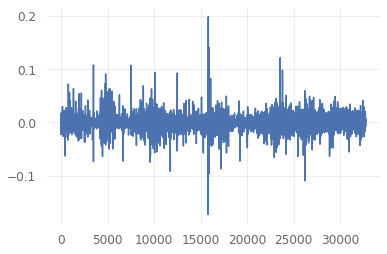

True

In [14]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

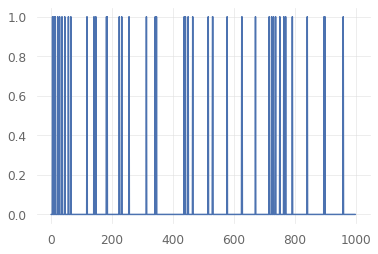

8.21%


In [15]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [16]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

0.007155721722591102

## Implement basic feature engineering

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [18]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.5)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/util

SelectBySingleFeaturePerformance(cv=5,
                                 estimator=RandomForestClassifier(n_jobs=6,
                                                                  random_state=1337),
                                 threshold=0.5)

In [19]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

others_dlr          1.000000
PCTRET_1            1.000000
lr_close            1.000000
LOGRET_1            1.000000
others_dr           1.000000
                      ...   
TOS_STDEVALL_L_3    0.307458
TOS_STDEVALL_L_1    0.307457
TOS_STDEVALL_LR     0.307455
SUPERTs_7_3.0       0.300682
compsum                  NaN
Length: 432, dtype: float64

Text(0, 0.5, 'roc-auc')

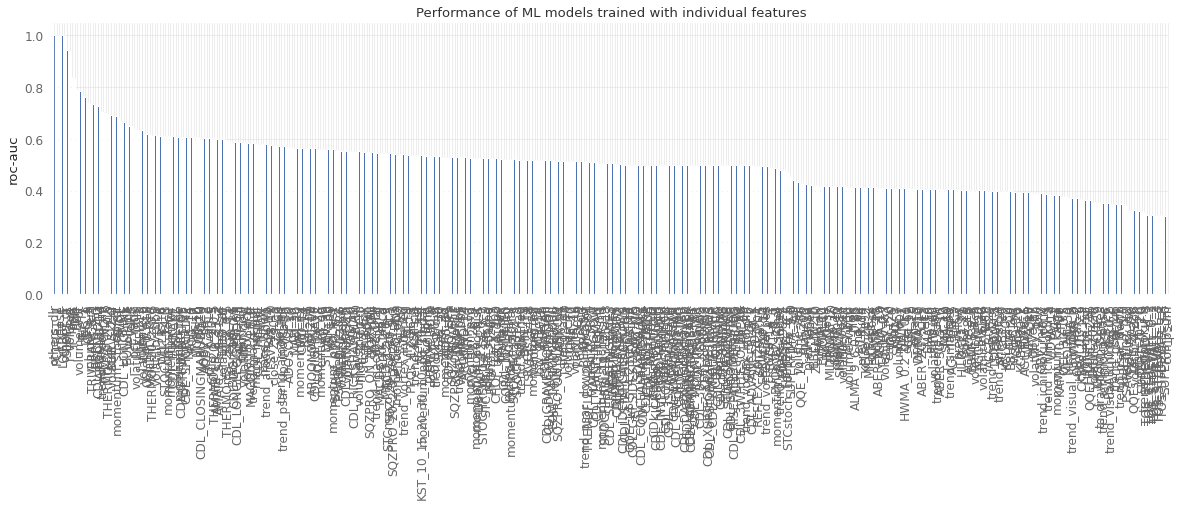

In [20]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [21]:
features_to_drop = sel.features_to_drop_
features_to_drop

['open',
 'high',
 'low',
 'close',
 'volume_adi',
 'volume_obv',
 'volume_vwap',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_diff',
 'trend_mass_index',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_visual_ichimoku_a',
 'trend_visual_ichimoku_b',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_pvo_signal',
 'momentum_kama',
 'others_cr',
 'prev_open',
 'prev_high',
 'prev_low',
 'prev_close',
 'ma_5',
 'ma_10',
 'ma_20',
 'ma_30',
 'ma_50',
 'ma_60',
 'ma_100',
 'ma_200',
 'ema_5',
 'ema_10',
 'ema_20',
 'ema_60',
 'ema_64',
 'ema_120',
 'CDL_3WHITESOLDIERS',
 'CDL_ADVANCEBLOCK',
 'HA_open',
 'HA_high',
 'HA_low',
 'HA_close',
 'EBSW_40_10',
 'REFLEX_20_20_0.04',
 'AR_26',
 '

In [22]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

162

In [23]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((10968, 271), (10969, 271), (10805, 271))

In [24]:
X_train.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_mfi',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_vortex_ind_neg',
 'trend_trix',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_stc',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_cci',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_aroon_ind',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
 'momentum_tsi',
 'momentum_uo',
 'momentum_stoch',
 'momentum_stoch_signal',
 'momentum_wr',
 'momentum_ao',
 'momentum_roc',
 'momentum_ppo',
 'momentum_ppo_signal',
 'mome

## Normalize the dataset subsets to make the model converge faster

In [25]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [26]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Write a reward scheme encouraging rare volatile upside trades

In [27]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [28]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## TODO: implement tuning

## Setup Trading Environment

In [29]:
import tensortrade.env.default as default

#from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.001
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
#bitstamp_options = ExchangeOptions(commission=commission)
#bitstamp = Exchange("bitstamp", 
#                    service=execute_order, 
#                    options=bitstamp_options)(price)
bitstamp = Exchange("bitstamp", 
                    service=execute_order)(price)

cash = Wallet(bitstamp, 50000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume") 
])

action_scheme = BSH(
    cash=cash,
    asset=asset
)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=30)

#reward_scheme = SimpleProfit(window_size=30)

reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [30]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 7877.4,
  'bitstamp:/USD:/free': 50000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 50000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 50000.0},
 'external': {'bitstamp:/open': 0.2987544165087819,
  'bitstamp:/high': 0.2963262602004091,
  'bitstamp:/low': 0.2981830815554469,
  'bitstamp:/close': 0.2974235578707555,
  'bitstamp:/volume': 0.06285271899720758,
  'bitstamp:/volume_cmf': 0.3526515935624286,
  'bitstamp:/volume_fi': 0.6098548010541026,
  'bitstamp:/volume_em': 0.0028434225221082485,
  'bitstamp:/volume_sma_em': 0.003306563276268447,
  'bitstamp:/volume_vpt': 0.5420122479217226,
  'bitstamp:/volume_mfi': 0.30389505331139943,
  'bitstamp:/volatility_bbw': 0.07908943976989953,
  'bitstamp:/volatility_bbp': 0.42721901509721405,
  'bitstamp:/volatility_bbhi': 0.0,
  'bitstamp:/volatility_bbli': 0.0,
  'bitstamp:/volatility_kcw': 0.065

## Setup and Train DQN Agent

In [31]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

242

In [32]:
#agent = DQNAgent(env)

#agent.train(batch_size=batch_size, 
#            n_steps=n_steps, 
#            n_episodes=n_episodes, 
#            memory_capacity=memory_capacity, 
#            save_path=save_path)

## Implement validation here

## Print basic quantstats report

In [33]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake and default parameters are used!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

#print_quantstats_full_report(env, data)

## Using new agents

In [34]:
max_allowed_loss = 0.90
min_periods = window_size  # Minimum of window_size

observer = default.observers.TensorTradeObserver(
    portfolio=portfolio,
    feed=feed,
    renderer_feed=renderer_feed,
    window_size=window_size,
    min_periods=min_periods
)

stopper = default.stoppers.MaxLossStopper(
    max_allowed_loss=max_allowed_loss
)

informer = default.informers.TensorTradeInformer()

renderer = default.renderers.PlotlyTradingChart()

In [35]:
import gym
env = gym.envs.register(
    id='TradingEnv-v0',
    entry_point='tensortrade.env.generic.environment:TradingEnv',
    kwargs={
        'portfolio': portfolio,
        'action_scheme': action_scheme,
        'reward_scheme': reward_scheme,
        'observer': observer,
        'stopper': stopper,
        'informer': informer,
        'feed': feed,
        'renderer_feed': renderer_feed,
        'renderer': renderer,
        'min_periods': min_periods,
        'window_size': window_size,
    },
)

In [ ]:
from tensorflow.keras.optimizers import Adam

import tensortrade.agents as agents
from tensortrade.agents import ACER
from tensortrade.agents.utils.buffers import ReplayBuffer1
from tensortrade.agents.utils.common import ModelReader, create_envs

envs = create_envs('TradingEnv-v0', 16, preprocess=False)
buffers = [
    ReplayBuffer1(5000, initial_size=500, batch_size=1) for _ in range(len(envs))
]
model_cfg = agents.agents['acer']['model']['cnn'][0]
optimizer = Adam(learning_rate=7e-4)
model = ModelReader(
    model_cfg,
    output_units=[envs[0].action_space.n, envs[0].action_space.n],
    input_shape=envs[0].observation_space.shape,
    optimizer=optimizer,
).build_model()
agent = ACER(envs, model, buffers, checkpoints=['acer-trading.tf'])
agent.fit(target_reward=19)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
